# DSI Project 4: West Nile Virus Prediction

## Background

[**West Nile virus**](https://www.cdc.gov/westnile/) is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

source: [kaggle](https://www.kaggle.com/c/predict-west-nile-virus/overview)

## Problem Statement

Due to a recent outbreak of the West Nile Virus in the city of Chicago, our Data Science team at the Disease and Treatment Agency has been tasked by the Centers for Disease Control (CDC) to develop a strategy to deploy the effective use of pesticides, by targeting spraying of pesticides to areas of high risk will help to mitigate future outbreaks.

Leveraging on weather, location, mosquito population and spraying data, the team will develop a binary classification model to predict the presence of the West Nile Virus in the city of Chicago. 

The model that achieves the highest ROC AUC score on the validation data set, will be selected as our production model. 

## Data Cleaning

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px

from math import radians, degrees, sin, cos, asin, acos, sqrt

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

plt.style.use('seaborn-muted')
sns.set_style(style='white')

%matplotlib inline

In [2]:
# load datasets 
train = pd.read_csv('./data/train.csv', parse_dates=['Date'])
test = pd.read_csv('./data/test.csv', parse_dates=['Date'])
spray = pd.read_csv('./data/spray.csv', parse_dates=['Date'])
weather = pd.read_csv('./data/weather.csv', parse_dates=['Date'])

In [3]:
# define a function for intial exploration of dataset

def data_exploration(df_name, df):
    """
    function to perform initial data exploration to check for 
    dataframe shape, datatype, null values and duplicates
    
    """
    print(f"DATASET: {df_name}")
    print("-------------------------------------")
    print("First 3 rows of dataset:")
    display(df.head(3))
    print("\n")
    # check shape of dataframe
    print(f"Shape of dataset: {df.shape}")
    print("\n")
    # check datatypes
    print("Columns & data types: ")
    df.info()
    print("\n")
    # check for null values
    print("Null values: ")
    if df.isnull().sum().sum() == 0:
        print("No null value")
    else:
        for col in df:
            print(f"{col}: {df[col].isnull().sum()}")
    print("\n")
    # check for duplicates
    if df.duplicated(subset=None, keep='first').any() == False:
        print("No duplicated row")
    else:
        duplicates = df[df.duplicated(subset=None, keep='first')]
        print(f"{len(duplicates)} duplicated rows in dataset.")

### Main Dataset - Train data set

In [4]:
data_exploration('Main dataset - Train', train)

DATASET: Main dataset - Train
-------------------------------------
First 3 rows of dataset:


Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0



Shape of dataset: (10506, 12)


Columns & data types: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64    

**Observation on Train dataset:**

* No null values
* Correct data types
* 813 duplicated rows 

Let's take a closer look at the duplicated rows.

In [5]:
train[train.duplicated(subset=None)].sort_values(['Address', 'Date']).head(10)

Date                                            Address  \
1122 2007-08-01      1000 East 67th Street, Chicago, IL 60637, USA   
1124 2007-08-01      1000 East 67th Street, Chicago, IL 60637, USA   
1039 2007-08-01  1000 North Central Park Avenue, Chicago, IL 60...   
2301 2007-08-21  1000 North Central Park Avenue, Chicago, IL 60...   
8909 2013-07-19  1000 North Central Park Avenue, Chicago, IL 60...   
8911 2013-07-19  1000 North Central Park Avenue, Chicago, IL 60...   
8914 2013-07-19  1000 North Central Park Avenue, Chicago, IL 60...   
8917 2013-07-19  1000 North Central Park Avenue, Chicago, IL 60...   
1018 2007-08-01  1000 South California Avenue, Chicago, IL 6061...   
1019 2007-08-01  1000 South California Avenue, Chicago, IL 6061...   

                     Species  Block              Street  Trap  \
1122          CULEX RESTUANS     10           E 67TH ST  T073   
1124           CULEX PIPIENS     10           E 67TH ST  T073   
1039           CULEX PIPIENS     10   N CENTRAL PARK DR  T030   
2301           CULEX PIPIENS     10   N CENTRAL PARK DR  T030   
8909  CULEX PIPIENS/RESTUANS     10   N CENTRAL PARK DR  T030   
8911  CULEX PIPIENS/RESTUANS     10   N CENTRAL PARK DR  T030   
8914  CULEX PIPIENS/RESTUANS     10   N CENTRAL PARK DR  T030   
8917          CULEX RESTUANS     10   N CENTRAL PARK DR  T030   
1018  CULEX PIPIENS/RESTUANS     10    S CALIFORNIA AVE  T088   
1019  CULEX PIPIENS/RESTUANS     10    S CALIFORNIA AVE  T088   

                    AddressNumberAndStreet   Latitude  Longitude  \
1122          1000  E 67TH ST, Chicago, IL  41.773215 -87.600880   
1124          1000  E 67TH ST, Chicago, IL  41.773215 -87.600880   
1039  1000  N CENTRAL PARK DR, Chicago, IL  41.899230 -87.716788   
2301  1000  N CENTRAL PARK DR, Chicago, IL  41.899230 -87.716788   
8909  1000  N CENTRAL PARK DR, Chicago, IL  41.899230 -87.716788   
8911  1000  N CENTRAL PARK DR, Chicago, IL  41.899230 -87.716788   
8914  1000  N CENTRAL PARK DR, Chicago, IL  41.899230 -87.716788   
8917  1000  N CENTRAL PARK DR, Chicago, IL  41.899230 -87.716788   
1018   1000  S CALIFORNIA AVE, Chicago, IL  41.869107 -87.696293   
1019   1000  S CALIFORNIA AVE, Chicago, IL  41.869107 -87.696293   

      AddressAccuracy  NumMosquitos  WnvPresent  
1122                8             1           0  
1124                8             1           0  
1039                9             1           0  
2301                9             1           0  
8909                9            50           0  
8911                9            50           0  
8914                9            50           0  
8917                9            50           0  
1018                9             3           0  
1019                9             3           0

Duplicates seem to arise from cases where trap in the same location have multiple records on the same day. However, we need to be careful in dropping the duplicates because the data are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

One way to handle this is to sum the number of mosquitoes for records where the Date, Species, Trap, Latitude and Longitude are the same.

To do that, we will first drop the Address columns (since we will base on Latitude and Longitude instead).

In [6]:
train.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], 
           axis=1, inplace=True)

Then, we will group the records by Date, Species, Trap, Latitude and Longitude 

In [7]:
# keep a copy of original train dataframe
train_original = train.copy()

In [8]:
# aggregate the duplicated rows
train = train.groupby(['Date', 'Species', 'Trap', 'Latitude', 'Longitude']).sum().reset_index()
train['WnvPresent'] = (train['WnvPresent'] > 0).astype(int)

In [9]:
train.describe().T

count       mean        std        min        25%        50%  \
Latitude      8475.0  41.844618   0.106609  41.644612  41.750498  41.857402   
Longitude     8475.0 -87.694788   0.084063 -87.930995 -87.752329 -87.694991   
NumMosquitos  8475.0  15.933805  75.084707   1.000000   2.000000   4.000000   
WnvPresent    8475.0   0.053923   0.225880   0.000000   0.000000   0.000000   

                    75%          max  
Latitude      41.944869    42.017430  
Longitude    -87.642984   -87.531635  
NumMosquitos  11.000000  2532.000000  
WnvPresent     0.000000     1.000000

The Latitude and Longitude range in the train dataset seems to be within range.

The maximum number of mosquitos seem high. Let's check.

In [10]:
train[train['NumMosquitos'] > 1000]

Date                 Species  Trap   Latitude  Longitude  \
564  2007-07-25           CULEX PIPIENS  T115  41.673408 -87.599862   
722  2007-08-01           CULEX PIPIENS  T115  41.673408 -87.599862   
1188 2007-08-08           CULEX PIPIENS  T115  41.673408 -87.599862   
1190 2007-08-08           CULEX PIPIENS  T138  41.726465 -87.585413   
1450 2007-08-16           CULEX PIPIENS  T115  41.673408 -87.599862   
1666 2007-08-22           CULEX PIPIENS  T115  41.673408 -87.599862   
1669 2007-08-22           CULEX PIPIENS  T138  41.726465 -87.585413   
1897 2007-08-28           CULEX PIPIENS  T115  41.673408 -87.599862   
2032 2007-09-05           CULEX PIPIENS  T115  41.673408 -87.599862   
3196 2009-06-22  CULEX PIPIENS/RESTUANS  T900  41.974689 -87.890615   

      NumMosquitos  WnvPresent  
564           2356           1  
722           1543           0  
1188          1310           1  
1190          1658           1  
1450          2532           1  
1666          1554           1  
1669          1054           1  
1897          2207           1  
2032          1648           1  
3196          1520           0

In Year 2007, there seems to be some 'hot zones' at trap T115 and T138. We will do some EDA on this later.

In [11]:
# add month & year columns
train['Month'] = train['Date'].dt.month
train['Year'] = train['Date'].dt.year

In [12]:
train.head()

Date                 Species  Trap   Latitude  Longitude  \
0 2007-05-29           CULEX PIPIENS  T096  41.731922 -87.677512   
1 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
2 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T048  41.867108 -87.654224   
4 2007-05-29  CULEX PIPIENS/RESTUANS  T050  41.919343 -87.694259   

   NumMosquitos  WnvPresent  Month  Year  
0             1           0      5  2007  
1             1           0      5  2007  
2             1           0      5  2007  
3             1           0      5  2007  
4             1           0      5  2007

### Main Dataset - Test data set

In [13]:
data_exploration('Main dataset - Test', test)

DATASET: Main dataset - Test
-------------------------------------
First 3 rows of dataset:


Id       Date                                            Address  \
0   1 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1   2 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2   3 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2           CULEX PIPIENS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
2  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9



Shape of dataset: (116293, 11)


Columns & data types: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
dtypes: datetime64[ns](1), float64(2),

**Observation on Test dataset:**

* No null value and duplicated row
* Correct data types
* As compared to Train dataset, there is no 'NumMosquitos' and 'WnvPresent' (which is the target variable). There is also an 'Id' column which is needed for Kaggle submission.

Similar to the train data, we will drop the Address columns.

In [14]:
test.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], 
           axis=1, inplace=True)

In [15]:
test.shape

(116293, 6)

In [16]:
test.describe().T

count          mean           std        min           25%  \
Id         116293.0  58147.000000  33571.041765   1.000000  29074.000000   
Latitude   116293.0     41.849389      0.106593  41.644612     41.753411   
Longitude  116293.0    -87.693658      0.080699 -87.930995    -87.750938   

                    50%           75%            max  
Id         58147.000000  87220.000000  116293.000000  
Latitude      41.862292     41.951866      42.017430  
Longitude    -87.694991    -87.648860     -87.531635

The Latitude and Longitude range in the test dataset seems to be within range.

In [17]:
# add month & year columns
test['Month'] = test['Date'].dt.month
test['Year'] = test['Date'].dt.year

In [18]:
test.head()

Id       Date                 Species  Trap  Latitude  Longitude  Month  \
0   1 2008-06-11  CULEX PIPIENS/RESTUANS  T002  41.95469 -87.800991      6   
1   2 2008-06-11          CULEX RESTUANS  T002  41.95469 -87.800991      6   
2   3 2008-06-11           CULEX PIPIENS  T002  41.95469 -87.800991      6   
3   4 2008-06-11        CULEX SALINARIUS  T002  41.95469 -87.800991      6   
4   5 2008-06-11         CULEX TERRITANS  T002  41.95469 -87.800991      6   

   Year  
0  2008  
1  2008  
2  2008  
3  2008  
4  2008

### Spray Dataset

In [19]:
data_exploration('Spray dataset', spray)

DATASET: Spray dataset
-------------------------------------
First 3 rows of dataset:


Date        Time   Latitude  Longitude
0 2011-08-29  6:56:58 PM  42.391623 -88.089163
1 2011-08-29  6:57:08 PM  42.391348 -88.089163
2 2011-08-29  6:57:18 PM  42.391022 -88.089157



Shape of dataset: (14835, 4)


Columns & data types: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14835 non-null  datetime64[ns]
 1   Time       14251 non-null  object        
 2   Latitude   14835 non-null  float64       
 3   Longitude  14835 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 463.7+ KB


Null values: 
Date: 0
Time: 584
Latitude: 0
Longitude: 0


541 duplicated rows in dataset.


**Observation on Spray dataset:**

* No missing values in 'Date', 'Latitude', 'Longitude'
* 584 missing values for 'Time' 
* 541 duplicated rows

Let's use the Missingno matrix to visualise where are the missing values in the 'Time' column. 

<Figure size 1080x576 with 0 Axes>

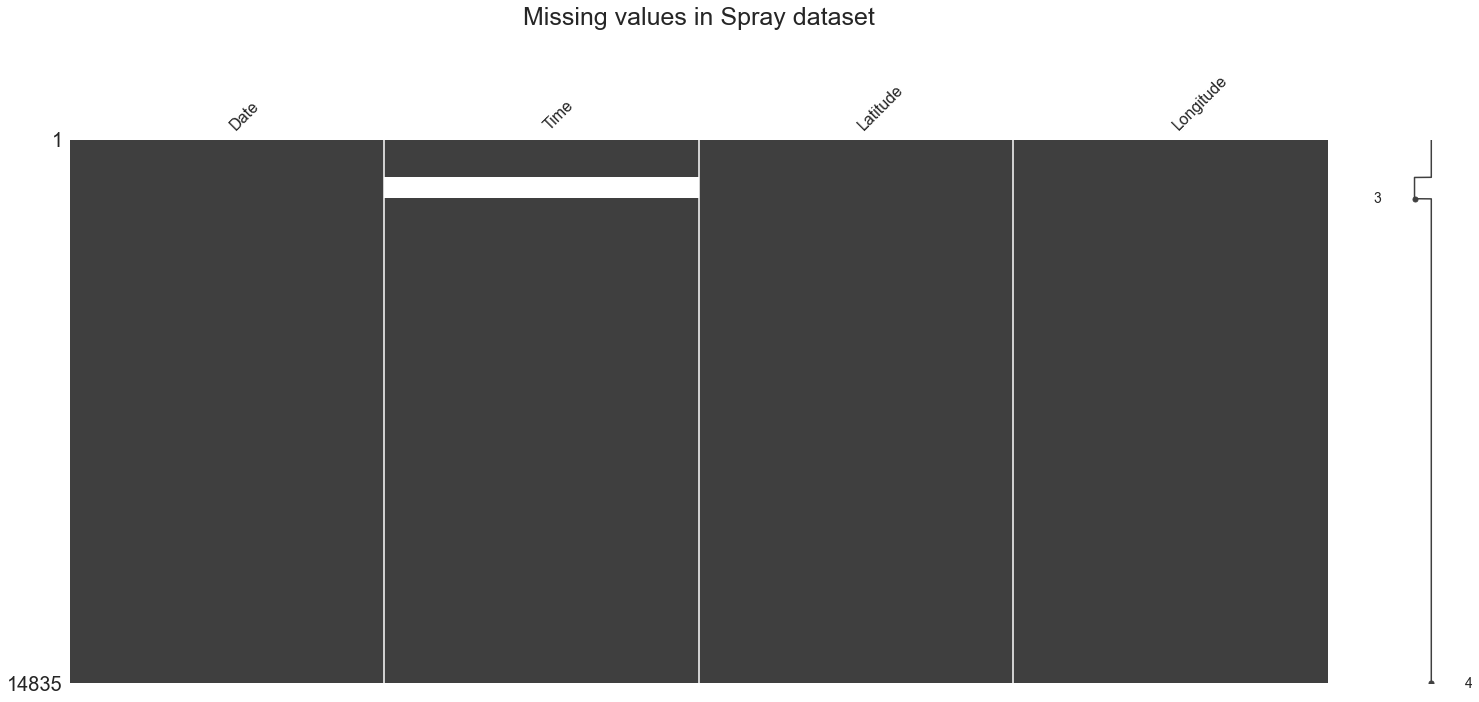

In [20]:
plt.figure(figsize=(15, 8));
msno.matrix(spray);
plt.title('Missing values in Spray dataset', fontsize=25, y=1.2);

In [21]:
spray[spray['Time'].isnull()]['Date'].value_counts()

2011-09-07    584
Name: Date, dtype: int64

All missing values for 'Time' belong to records on the date 2011-09-07. The Time feature may or may not be used for modelling. Let's keep in view to see if we need to impute the missing values.

Let's also take a look at the duplicated rows.

In [22]:
spray[spray.duplicated(subset=None)].sort_values('Date').head()

Date        Time   Latitude  Longitude
485 2011-09-07  7:43:40 PM  41.983917 -87.793088
857 2011-09-07  7:44:32 PM  41.986460 -87.794225
856 2011-09-07  7:44:32 PM  41.986460 -87.794225
855 2011-09-07  7:44:32 PM  41.986460 -87.794225
854 2011-09-07  7:44:32 PM  41.986460 -87.794225

In [23]:
spray[spray.duplicated(subset=None)]['Date'].value_counts()

2011-09-07    541
Name: Date, dtype: int64

All duplicated rows are also records on the date 2011-09-07.

Let's go ahead and drop the duplicated rows.

In [24]:
spray.drop_duplicates(subset=None, keep='first', inplace=True)

In [25]:
spray.shape

(14294, 4)

In [26]:
spray.describe().T

count       mean       std        min        25%        50%  \
Latitude   14294.0  41.901739  0.105100  41.713925  41.782669  41.937578   
Longitude  14294.0 -87.734512  0.067599 -88.096468 -87.789607 -87.724781   

                 75%        max  
Latitude   41.977217  42.395983  
Longitude -87.692107 -87.586727

Maximum value of Latitude seems to be out of range.

In [27]:
# remove records where Latitude is more than 42.1
spray = spray[spray['Latitude'] <=42.1]

### Weather dataset

In [28]:
data_exploration('Weather dataset', weather)

DATASET: Weather dataset
-------------------------------------
First 3 rows of dataset:


Station       Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1 2007-05-01    83    50   67     14        51      56    0    2   
1        2 2007-05-01    84    52   68      M        51      57    0    3   
2        1 2007-05-02    59    42   51     -3        42      47   14    0   

  Sunrise Sunset CodeSum Depth Water1 SnowFall PrecipTotal StnPressure  \
0    0448   1849             0      M      0.0        0.00       29.10   
1       -      -             M      M        M        0.00       29.18   
2    0447   1850      BR     0      M      0.0        0.00       29.38   

  SeaLevel  ResultSpeed  ResultDir AvgSpeed  
0    29.82          1.7         27      9.2  
1    29.82          2.7         25      9.6  
2    30.09         13.0          4     13.4



Shape of dataset: (2944, 22)


Columns & data types: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15 

**Observations on Weather dataset:**

* While there is seemingly no null value, the data dictionary stated that missing values are marked with 'M'.

* For the column SnowFall and PrecipTotal, trace values are marked with ' T'.

* For the column CodeSum, a blank refers to 'Moderate' according to the data dictionary

* Several columns have object data type when the values should be numeric, e.g. Tavg, Depart, WelBulb, Heat, Cool, Depth, Water1, SnowFall, PrecipTotal, StnPressure, SeaLevel, AvgSpeed

* Sunrise and Sunset should be time (in HH:MM) but currently are in object data types.

* No duplicated row

In [29]:
weather['SnowFall'].unique()

array(['0.0', 'M', '  T', '0.1'], dtype=object)

In [30]:
weather['PrecipTotal'].unique()

array(['0.00', '  T', '0.13', '0.02', '0.38', '0.60', '0.14', '0.07',
       '0.11', '0.09', '1.01', '0.28', '0.04', '0.08', '0.01', '0.53',
       '0.19', '0.21', '0.32', '0.39', '0.31', '0.42', '0.27', '0.16',
       '0.58', '0.93', '0.05', '0.34', '0.15', '0.35', 'M', '0.40',
       '0.66', '0.30', '0.24', '0.43', '1.55', '0.92', '0.89', '0.17',
       '0.03', '1.43', '0.97', '0.26', '1.31', '0.06', '0.46', '0.29',
       '0.23', '0.41', '0.45', '0.83', '1.33', '0.91', '0.48', '0.37',
       '0.88', '2.35', '1.96', '0.20', '0.25', '0.18', '0.67', '0.36',
       '0.33', '1.28', '0.74', '0.76', '0.71', '0.95', '1.46', '0.12',
       '0.52', '0.64', '0.22', '1.24', '0.72', '0.73', '0.65', '1.61',
       '1.22', '0.50', '1.05', '2.43', '0.59', '2.90', '2.68', '1.23',
       '0.62', '6.64', '3.07', '1.44', '1.75', '0.82', '0.80', '0.86',
       '0.63', '0.55', '1.03', '0.70', '1.73', '1.38', '0.44', '1.14',
       '1.07', '3.97', '0.87', '0.78', '1.12', '0.68', '0.10', '0.61',
       '0.

For Trace value ' T', we can consider imputing with a small value below 0.01, e.g. 0.005.

In [31]:
for col in weather.columns:
    weather[col].replace('M', np.nan, inplace=True)      # for columns using 'M' for missing values
    weather[col].replace('  T', 0.005, inplace=True)     # for SnowFall and PrecipTotal columns 
    weather[col].replace('-', np.nan, inplace=True)      # for Sunrise and Sunset columns
    weather[col].replace(' ', 'Moderate',inplace=True)   # for CodeSum column

In [32]:
weather.head()

Station       Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1 2007-05-01    83    50   67     14        51      56    0    2   
1        2 2007-05-01    84    52   68    NaN        51      57    0    3   
2        1 2007-05-02    59    42   51     -3        42      47   14    0   
3        2 2007-05-02    60    43   52    NaN        42      47   13    0   
4        1 2007-05-03    66    46   56      2        40      48    9    0   

  Sunrise Sunset   CodeSum Depth  Water1 SnowFall PrecipTotal StnPressure  \
0    0448   1849  Moderate     0     NaN      0.0        0.00       29.10   
1     NaN    NaN  Moderate   NaN     NaN      NaN        0.00       29.18   
2    0447   1850        BR     0     NaN      0.0        0.00       29.38   
3     NaN    NaN     BR HZ   NaN     NaN      NaN        0.00       29.44   
4    0446   1851  Moderate     0     NaN      0.0        0.00       29.39   

  SeaLevel  ResultSpeed  ResultDir AvgSpeed  
0    29.82          1.7         27      9.2  
1    29.82          2.7         25      9.6  
2    30.09         13.0          4     13.4  
3    30.08         13.3          2     13.4  
4    30.12         11.7          7     11.9

Now that the values are corrected, let's check for missing values again.

In [33]:
weather.isnull().agg(['sum', 'mean']).T.sort_values('sum', ascending=False)

sum      mean
Water1       2944.0  1.000000
Sunset       1472.0  0.500000
Depth        1472.0  0.500000
Depart       1472.0  0.500000
SnowFall     1472.0  0.500000
Sunrise      1472.0  0.500000
Tavg           11.0  0.003736
Heat           11.0  0.003736
Cool           11.0  0.003736
SeaLevel        9.0  0.003057
StnPressure     4.0  0.001359
WetBulb         4.0  0.001359
AvgSpeed        3.0  0.001019
PrecipTotal     2.0  0.000679
CodeSum         0.0  0.000000
Date            0.0  0.000000
DewPoint        0.0  0.000000
Tmin            0.0  0.000000
Tmax            0.0  0.000000
ResultSpeed     0.0  0.000000
ResultDir       0.0  0.000000
Station         0.0  0.000000

**Further observations:**

* Water1 have missing values in all records.
* Sunrise, Sunset, Depth, Depart, SnowFall have missing values in half of the records (which we will take a look from which station)
* Handful of missing values in Tavg, Heat, Cool, SeaLevel, StnPressure, WetBulb, AvgSpeed and PrecipTotal

Let's check for missing values by Station.

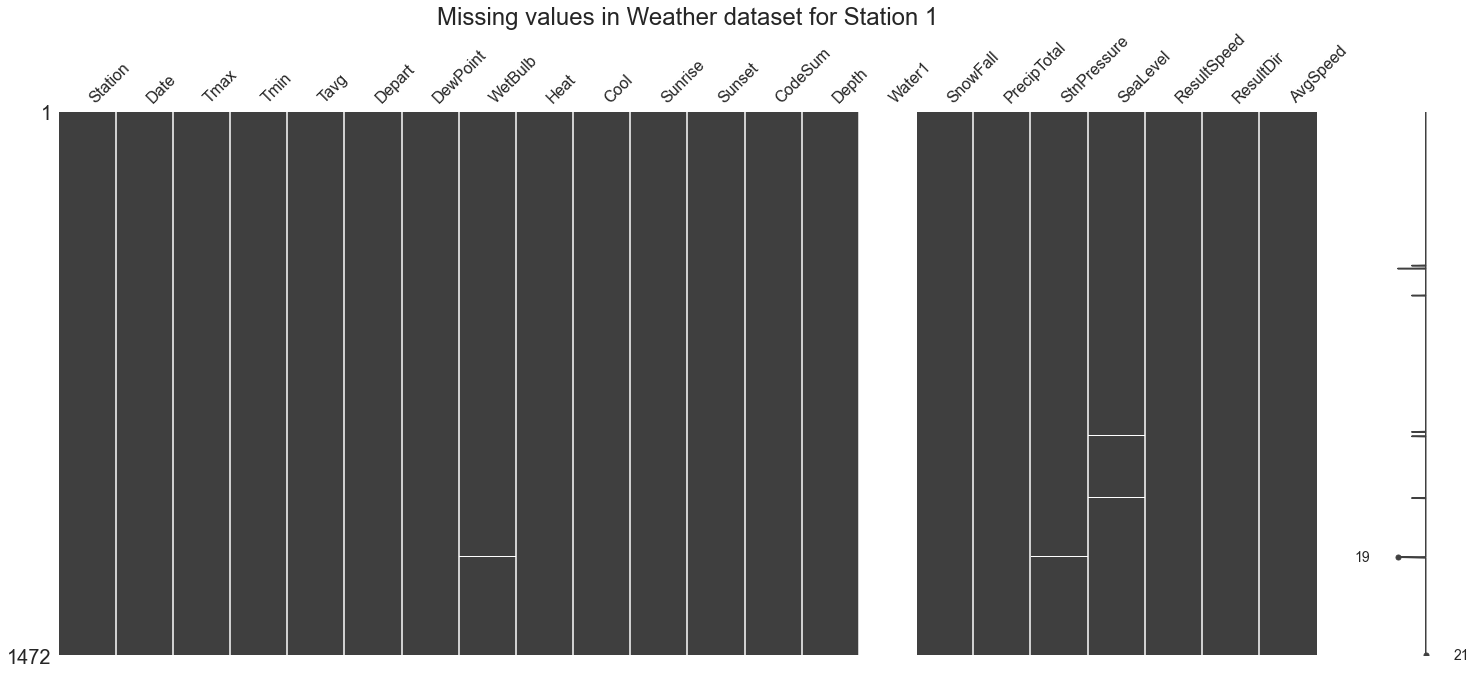

In [34]:
msno.matrix(weather[weather['Station'] == 1]);
plt.title('Missing values in Weather dataset for Station 1', fontsize=24, y=1.15);

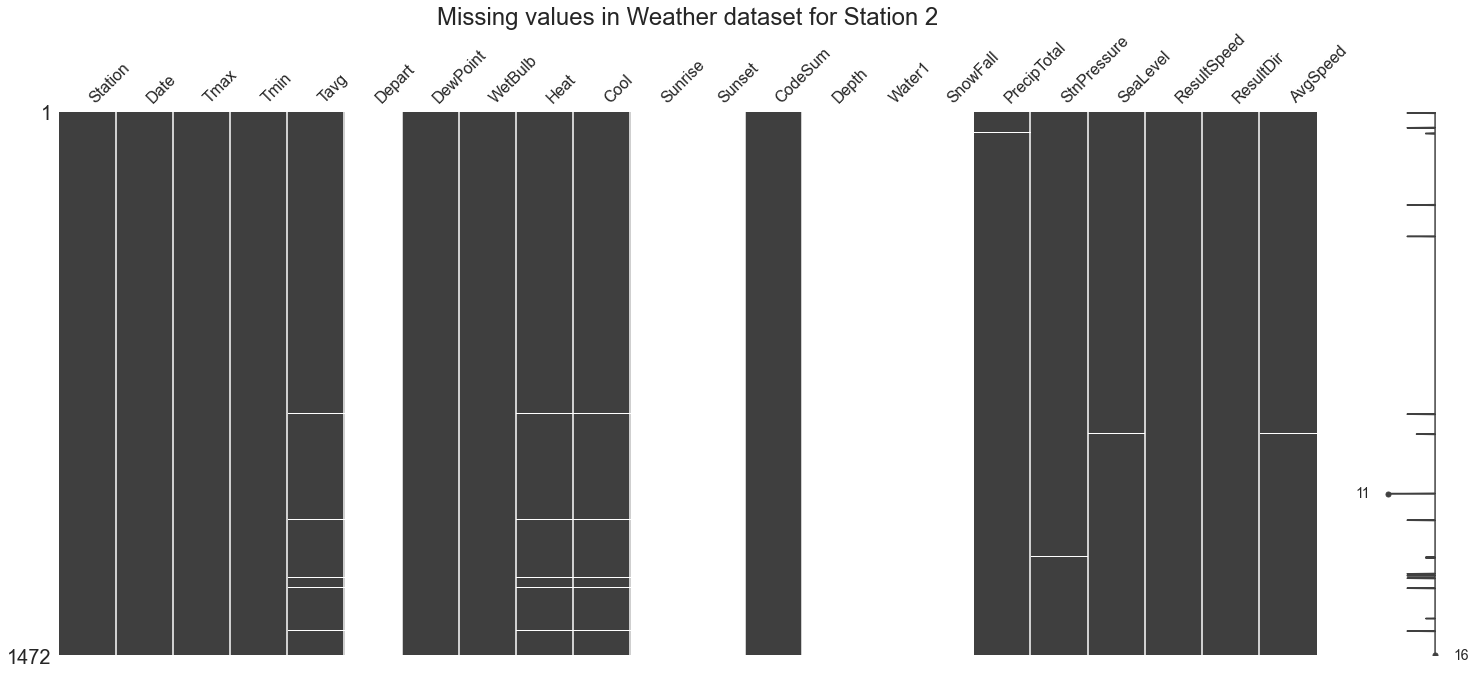

In [35]:
msno.matrix(weather[weather['Station'] == 2]);
plt.title('Missing values in Weather dataset for Station 2', fontsize=24, y=1.15);

**Observation:**

* Missing values in Depart, Sunrise, Sunset, Depth and SnowFall are contributed by Station 2 (1472 records).

* Water1 values are missing for both Stations.

#### Missing values in Tavg

Let's impute the missing values for Tavg by taking average of the day's maximum temperature (Tmax) and minimum temperature (Tmin).

In [36]:
weather['Tavg'].fillna(((weather['Tmax'] + weather['Tmin'])/2),inplace=True)

In [37]:
# convert to integer data type to align to Tmax and Tmin
weather['Tavg'] = weather['Tavg'].astype('int64')

#### Missing values in WetBulb

In [38]:
weather[weather['WetBulb'].isnull()]

Station       Date  Tmax  Tmin  Tavg Depart  DewPoint WetBulb Heat Cool  \
848         1 2009-06-26    86    69    78      7        60     NaN    0   13   
2410        1 2013-08-10    81    64    73      0        57     NaN    0    8   
2412        1 2013-08-11    81    60    71     -2        61     NaN    0    6   
2415        2 2013-08-12    85    69    77    NaN        63     NaN    0   12   

     Sunrise Sunset   CodeSum Depth  Water1 SnowFall PrecipTotal StnPressure  \
848     0418   1931  Moderate     0     NaN      0.0        0.00         NaN   
2410    0454   1900  Moderate     0     NaN      0.0        0.00         NaN   
2412    0455   1859        RA     0     NaN      0.0        0.01       29.35   
2415     NaN    NaN        RA   NaN     NaN      NaN        0.66       29.27   

     SeaLevel  ResultSpeed  ResultDir AvgSpeed  
848     29.85          6.4          4      8.2  
2410    30.08          5.3          5      6.5  
2412    30.07          2.0         27      3.0  
2415    29.92          4.5         26      7.7

Based on our research, WetBulb and DewPoint are measurements of humidity.

**Wet Bulb** temperature is the adiabatic saturation temperature, and can be measured by using a thermometer with the bulb wrapped in wet muslin. The temperature difference between the dry bulb and wet bulb, depends on the humidity of the air. **The Wet Bulb temperature is always between the Dry Bulb temperature and the Dew Point**.

**Dry Bulb** Temperature refers basically to the ambient air temperature, for which **Tavg** in our dataset can be an approximate.

**Dew Point** is the temperature where water vapor starts to condense out of the air (the temperature at which air becomes completely saturated). If the dew-point temperature is close to the dry air temperature - the relative humidity is high if the dew point is well below the dry air temperature - the relative humidity is low.

source: https://www.engineeringtoolbox.com/dry-wet-bulb-dew-point-air-d_682.html

Let's fill the WetBulb as mid point between Tavg and DewPoint, i.e. 

*WetBulb = (Tavg + DewPoint) / 2*

In [39]:
wetbulb_na_index = weather[weather['WetBulb'].isnull()].index

for i in wetbulb_na_index:
    weather.loc[i,'WetBulb'] = (weather.loc[i,'Tavg'] + weather.loc[i,'DewPoint']) /2

#### Missing Values in Heat and Cool columns

In [40]:
weather[weather['Heat'].isnull()]

Station       Date  Tmax  Tmin  Tavg Depart  DewPoint WetBulb Heat Cool  \
7           2 2007-05-04    78    51    64    NaN        42      50  NaN  NaN   
505         2 2008-07-08    86    46    66    NaN        68      71  NaN  NaN   
675         2 2008-10-01    62    46    54    NaN        41      47  NaN  NaN   
1637        2 2011-07-22   100    71    85    NaN        70      74  NaN  NaN   
2067        2 2012-08-22    84    72    78    NaN        51      61  NaN  NaN   
2211        2 2013-05-02    71    42    56    NaN        39      45  NaN  NaN   
2501        2 2013-09-24    91    52    71    NaN        48      54  NaN  NaN   
2511        2 2013-09-29    84    53    68    NaN        48      54  NaN  NaN   
2525        2 2013-10-06    76    48    62    NaN        44      50  NaN  NaN   
2579        2 2014-05-02    80    47    63    NaN        43      47  NaN  NaN   
2811        2 2014-08-26    86    49    67    NaN        68      71  NaN  NaN   

     Sunrise Sunset     CodeSum Depth  Water1 SnowFall PrecipTotal  \
7        NaN    NaN    Moderate   NaN     NaN      NaN        0.00   
505      NaN    NaN       TS RA   NaN     NaN      NaN        0.28   
675      NaN    NaN    Moderate   NaN     NaN      NaN        0.00   
1637     NaN    NaN  TS TSRA BR   NaN     NaN      NaN        0.14   
2067     NaN    NaN    Moderate   NaN     NaN      NaN        0.00   
2211     NaN    NaN    Moderate   NaN     NaN      NaN        0.00   
2501     NaN    NaN    Moderate   NaN     NaN      NaN        0.00   
2511     NaN    NaN       RA BR   NaN     NaN      NaN        0.22   
2525     NaN    NaN    RA DZ BR   NaN     NaN      NaN        0.06   
2579     NaN    NaN          RA   NaN     NaN      NaN        0.04   
2811     NaN    NaN    Moderate   NaN     NaN      NaN       0.005   

     StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed  
7          29.36    30.04         10.1          7     10.4  
505        29.16    29.80          7.4         24      8.3  
675        29.30    29.96         10.9         33     11.0  
1637       29.23    29.86          3.8         10      8.2  
2067       29.39      NaN          4.7         19      NaN  
2211       29.51    30.17         15.8          2     16.1  
2501       29.33    30.00          5.8          9      7.7  
2511       29.36    30.01          6.3         36      7.8  
2525       29.10    29.76         10.1         25     10.6  
2579       29.10    29.79         10.7         23     11.9  
2811       29.41    30.04          1.3         15      5.8

In [41]:
# fill station 2 missing values with station 1 data
weather['Heat'].fillna(method='ffill', inplace=True)
weather['Cool'].fillna(method='ffill', inplace=True)

#### Missing Values in SeaLevel

In [42]:
weather[weather['SeaLevel'].isnull()]

Station       Date  Tmax  Tmin  Tavg Depart  DewPoint WetBulb Heat Cool  \
87          2 2007-06-13    86    68    77    NaN        53      62    0   12   
832         1 2009-06-18    80    61    71      1        63      67    0    6   
994         1 2009-09-07    77    59    68      1        59      62    0    3   
1732        1 2011-09-08    75    57    66      0        53      59    0    1   
1745        2 2011-09-14    60    48    54    NaN        45      51   11    0   
1756        1 2011-09-20    74    49    62      0        54      58    3    0   
2067        2 2012-08-22    84    72    78    NaN        51      61    0    5   
2090        1 2012-09-03    88    71    80     12        70      73    0   15   
2743        2 2014-07-23    76    64    70    NaN        56      61    0    5   

     Sunrise Sunset       CodeSum Depth  Water1 SnowFall PrecipTotal  \
87       NaN    NaN      Moderate   NaN     NaN      NaN        0.00   
832     0416   1929         RA BR     0     NaN      0.0        0.12   
994     0523   1817            BR     0     NaN      0.0        0.00   
1732    0524   1815            RA     0     NaN      0.0       0.005   
1745     NaN    NaN   RA BR HZ FU   NaN     NaN      NaN       0.005   
1756    0537   1753  MIFG BCFG BR     0     NaN      0.0        0.00   
2067     NaN    NaN      Moderate   NaN     NaN      NaN        0.00   
2090    0519   1824            BR     0     NaN      0.0        0.00   
2743     NaN    NaN      Moderate   NaN     NaN      NaN        0.00   

     StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed  
87           NaN      NaN          7.0          5      NaN  
832        29.08      NaN          6.7         16      7.9  
994        29.39      NaN          5.8          3      4.0  
1732       29.34      NaN         13.0          2     13.4  
1745       29.47      NaN          6.0         32      NaN  
1756       29.26      NaN          7.3         18      7.3  
2067       29.39      NaN          4.7         19      NaN  
2090       29.17      NaN          4.6          6      4.4  
2743       29.47      NaN         16.4          2     16.7

In [43]:
def fill_cross_stations(df, column):
    na_index = df[df[column].isnull()].index
    for i in na_index:
        if df.loc[i,'Station'] == 1: 
            weather.loc[i, column] = weather.loc[i+1,column]
        else: 
            weather.loc[i, column] = weather.loc[i-1,column]

In [44]:
fill_cross_stations(weather, 'SeaLevel')

#### Missing Values in StnPressure

In [45]:
weather[weather['StnPressure'].isnull()]

Station       Date  Tmax  Tmin  Tavg Depart  DewPoint WetBulb Heat Cool  \
87          2 2007-06-13    86    68    77    NaN        53      62    0   12   
848         1 2009-06-26    86    69    78      7        60      69    0   13   
2410        1 2013-08-10    81    64    73      0        57      65    0    8   
2411        2 2013-08-10    81    68    75    NaN        55      63    0   10   

     Sunrise Sunset   CodeSum Depth  Water1 SnowFall PrecipTotal StnPressure  \
87       NaN    NaN  Moderate   NaN     NaN      NaN        0.00         NaN   
848     0418   1931  Moderate     0     NaN      0.0        0.00         NaN   
2410    0454   1900  Moderate     0     NaN      0.0        0.00         NaN   
2411     NaN    NaN  Moderate   NaN     NaN      NaN        0.00         NaN   

     SeaLevel  ResultSpeed  ResultDir AvgSpeed  
87      30.09          7.0          5      NaN  
848     29.85          6.4          4      8.2  
2410    30.08          5.3          5      6.5  
2411    30.07          6.0          6      7.4

In [46]:
# fill na for station 1 with station 2, and vice versa
fill_cross_stations(weather, 'StnPressure')

# where both station 1 & 2 are null, fill with previous day data
stnpressure_na_index = weather[weather['StnPressure'].isnull()].index
for i in stnpressure_na_index:
    weather.loc[i,'StnPressure'] = weather.loc[i-2,'StnPressure']

#### Missing Values in AvgSpeed and PrecipTotal

In [47]:
weather[weather['AvgSpeed'].isnull()]

Station       Date  Tmax  Tmin  Tavg Depart  DewPoint WetBulb Heat Cool  \
87          2 2007-06-13    86    68    77    NaN        53      62    0   12   
1745        2 2011-09-14    60    48    54    NaN        45      51   11    0   
2067        2 2012-08-22    84    72    78    NaN        51      61    0    5   

     Sunrise Sunset      CodeSum Depth  Water1 SnowFall PrecipTotal  \
87       NaN    NaN     Moderate   NaN     NaN      NaN        0.00   
1745     NaN    NaN  RA BR HZ FU   NaN     NaN      NaN       0.005   
2067     NaN    NaN     Moderate   NaN     NaN      NaN        0.00   

     StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed  
87         29.36    30.09          7.0          5      NaN  
1745       29.47    30.09          6.0         32      NaN  
2067       29.39    30.07          4.7         19      NaN

In [48]:
weather[weather['PrecipTotal'].isnull()]

Station       Date  Tmax  Tmin  Tavg Depart  DewPoint WetBulb Heat Cool  \
117        2 2007-06-28    73    61    67    NaN        56      61    0    2   
119        2 2007-06-29    71    56    64    NaN        56      60    1    0   

    Sunrise Sunset   CodeSum Depth  Water1 SnowFall PrecipTotal StnPressure  \
117     NaN    NaN  Moderate   NaN     NaN      NaN         NaN       29.43   
119     NaN    NaN  Moderate   NaN     NaN      NaN         NaN       29.47   

    SeaLevel  ResultSpeed  ResultDir AvgSpeed  
117    30.07         12.2          2     13.3  
119    30.11          7.4          2      8.2

In [49]:
# fill na for station 1 with station 2, and vice versa
fill_cross_stations(weather, 'AvgSpeed')
fill_cross_stations(weather, 'PrecipTotal')

#### Missing Values in Water1, Sunrise, Sunset, Depart, SnowFall and Depth

In [50]:
# Since there is no value in Water1 for all records, let's drop the column
weather.drop(columns = 'Water1', inplace=True)

In [51]:
# for the rest of the columns with missing values in Station 2, fill with values from Station 1

missing_station2 = ['Sunrise', 'Sunset', 'Depart', 'SnowFall', 'Depth']

for col in missing_station2:
    weather[col].fillna(method='ffill', inplace=True)

In [52]:
# checking the remaining null values after cleaning
weather.isnull().sum().sum()

0

In [53]:
# converting numeric columns to float

col_to_float = ['Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool','Depth', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultDir', 'AvgSpeed']

for col in col_to_float:
    weather[col] = weather[col].astype(float)

In [54]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   float64       
 3   Tmin         2944 non-null   float64       
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   float64       
 6   DewPoint     2944 non-null   float64       
 7   WetBulb      2944 non-null   float64       
 8   Heat         2944 non-null   float64       
 9   Cool         2944 non-null   float64       
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   float64       
 14  SnowFall     2944 non-null   float64       
 15  PrecipTotal  2944 non-null   float64       
 16  StnPre

## EDA

#### Distrbution of Data by Date across Datasets

Let's look at the distribution of data points by date for the 4 datasets.

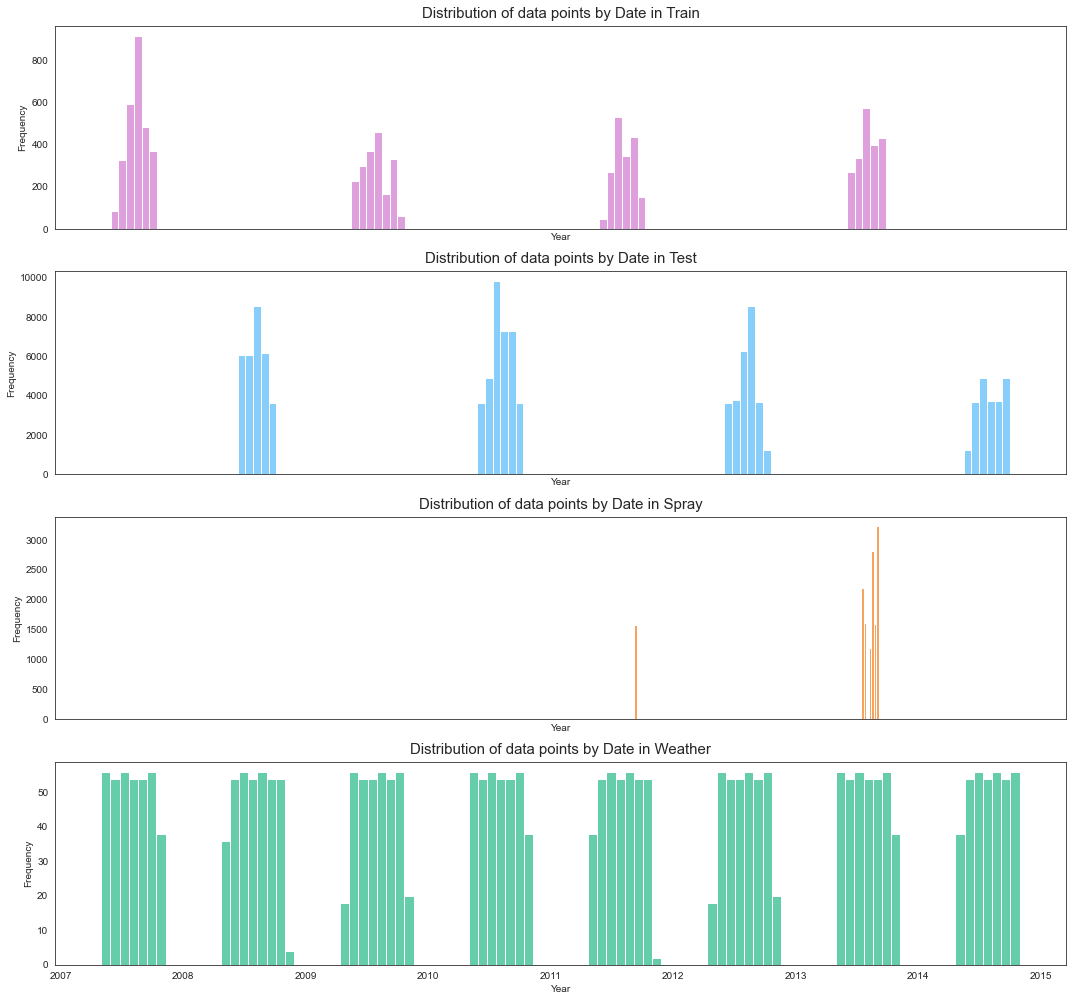

In [55]:
# plot histogram subplots to compare the date range across the 4 data sets
fig, ax = plt.subplots(nrows=4, figsize=(15,14), sharex=True)

df_list = [train, test, spray, weather] # List of our dataframes
title_list = ['Train', 'Test', 'Spray', 'Weather']
colors = ['plum', 'lightskyblue', 'sandybrown', 'mediumaquamarine']

for i, df in enumerate(df_list):
    ax[i].hist(df['Date'], bins=100, color=colors[i])
    ax[i].set_title('Distribution of data points by Date in ' + str(title_list[i]), size=15, y=1.01)
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('Year')

plt.tight_layout()

**Observations:**

* For the main dataset, we have data from 2007, 2009, 2011 and 2013 in the train dataset, and data from 2008, 2010, 2012 and 2014 in the test dataset.

* For the spray data, the dataset only contains information about spray effort in 2011 and 2013.

* As for weather data, we have data from 2007 to 2014.

#### Train Dataset

In [56]:
train.head()

Date                 Species  Trap   Latitude  Longitude  \
0 2007-05-29           CULEX PIPIENS  T096  41.731922 -87.677512   
1 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
2 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T048  41.867108 -87.654224   
4 2007-05-29  CULEX PIPIENS/RESTUANS  T050  41.919343 -87.694259   

   NumMosquitos  WnvPresent  Month  Year  
0             1           0      5  2007  
1             1           0      5  2007  
2             1           0      5  2007  
3             1           0      5  2007  
4             1           0      5  2007

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          8475 non-null   datetime64[ns]
 1   Species       8475 non-null   object        
 2   Trap          8475 non-null   object        
 3   Latitude      8475 non-null   float64       
 4   Longitude     8475 non-null   float64       
 5   NumMosquitos  8475 non-null   int64         
 6   WnvPresent    8475 non-null   int32         
 7   Month         8475 non-null   int64         
 8   Year          8475 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(3), object(2)
memory usage: 562.9+ KB


In [58]:
train['Year'].value_counts()

2007    2775
2013    2012
2009    1915
2011    1773
Name: Year, dtype: int64

#### Target Variable - WnvPresent

Since the aim of the project is to predict the present of West Nile Virus, let's take a look at our target variable WnvPresent.

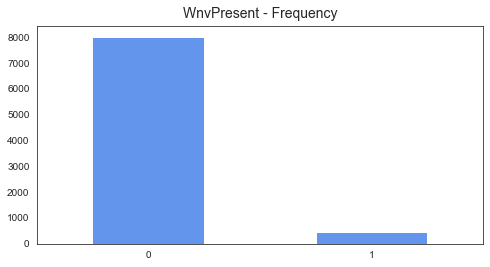

In [59]:
train['WnvPresent'].value_counts().plot(kind='bar', color='cornflowerblue', figsize=(8, 4))
plt.title('WnvPresent - Frequency', fontsize = 14, y=1.01)
plt.xticks(rotation=0);

In [60]:
train['WnvPresent'].value_counts(normalize=True)

0    0.946077
1    0.053923
Name: WnvPresent, dtype: float64

**Observation:**

* Imbalance class in the WnvPresent variable, which means that we will need to consider oversampling the positive class later.

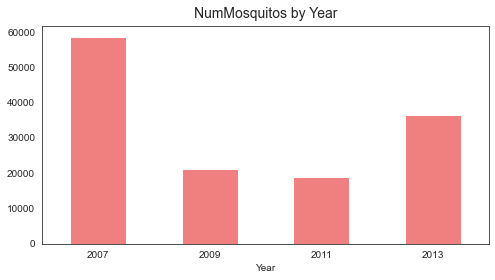

In [61]:
train.groupby('Year')['NumMosquitos'].sum().plot(kind='bar', color='lightcoral', figsize=(8,4))
plt.title('NumMosquitos by Year', fontsize = 14, y=1.01)
plt.xticks(rotation=0);

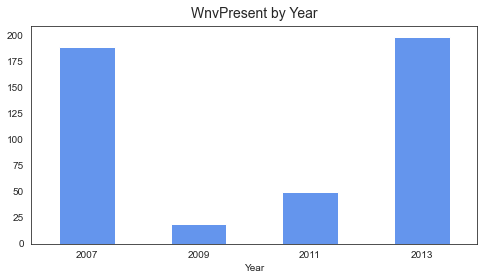

In [62]:
train.groupby('Year')['WnvPresent'].sum().plot(kind='bar', color='cornflowerblue', figsize=(8,4))
plt.title('WnvPresent by Year', fontsize = 14, y=1.01)
plt.xticks(rotation=0);

Year 2007 has the highest number of mosquitos and WnvPresence instances, followed by 2013. Relatively lower mosquito counts and WnvPresent instances in 2009 and 2011.

#### Seasonality in Number of Mosquitos and WnvPresent

In [63]:
# plot time series showing seasonality of number of mosquitos

mos_wnv_by_date=pd.DataFrame(train.groupby('Date')[['NumMosquitos','WnvPresent']].sum()).reset_index()

fig = px.line(mos_wnv_by_date, x='Date', y='NumMosquitos',title='Number of Mosquitos by Date')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

In [64]:
# plot time series showing seasonality of WnvPresent

fig = px.line(mos_wnv_by_date, x='Date', y='WnvPresent',title='WnvPresent by Date')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

Based ont the train dataset, the Number of Mosquitos and WnvPresent instances peak every year in August, and is most prominent in 2007 and 2013 as noted earlier.

#### Species of Mosquitos

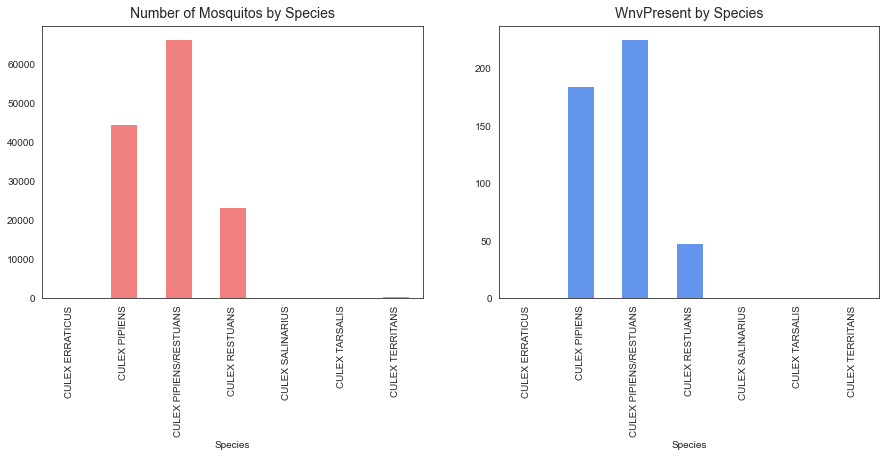

In [65]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
train.groupby('Species')['NumMosquitos'].sum().plot(kind='bar', color='lightcoral')
plt.title('Number of Mosquitos by Species', fontsize=14, y=1.01)
plt.subplot(1,2,2)
train.groupby('Species')['WnvPresent'].sum().plot(kind='bar', color='cornflowerblue')
plt.title('WnvPresent by Species', fontsize=14, y=1.01);

Culex Pipiens/Restuans and Culex Pipiens are the most common species both in numbers and in association with presence of West Nile Virus.

In [66]:
# plot time series showing seasonality of number of mosquitos by species

mos_wnv_by_species =pd.DataFrame(train.groupby(['Date','Species'])[['NumMosquitos','WnvPresent']].sum()).reset_index()

fig = px.line(mos_wnv_by_species, x='Date', y='NumMosquitos',title='Number of Mosquitos By Species',color='Species')


fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

In [67]:
# plot time series showing seasonality of WnvPresent by species

fig = px.line(mos_wnv_by_species, x='Date', y='WnvPresent',title='WnvPresent By Species',color='Species')


fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

#### Visualizing Number of Mosquitos by Location

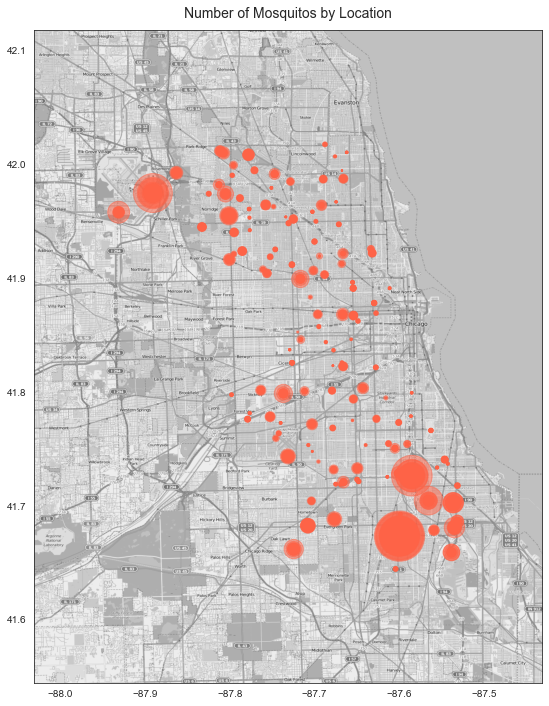

In [68]:
mapdata = np.loadtxt('./data/mapdata_copyright_openstreetmap_contributors.txt')

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
long_lat_box = (train['Longitude'].min()-0.1, train['Longitude'].max()+0.1,
               train['Latitude'].min()-0.1, train['Latitude'].max()+0.1)

plt.figure(figsize=(10,12))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=long_lat_box, 
           aspect=aspect)

long = train['Longitude']
lat = train['Latitude']
size = train['NumMosquitos']
size_scatter = plt.scatter(x=long, y=lat, s=size, c='tomato', alpha=0.5)

plt.title('Number of Mosquitos by Location', fontsize=14, y=1.01);

#### Visualizing the location of traps, spray and weather stations

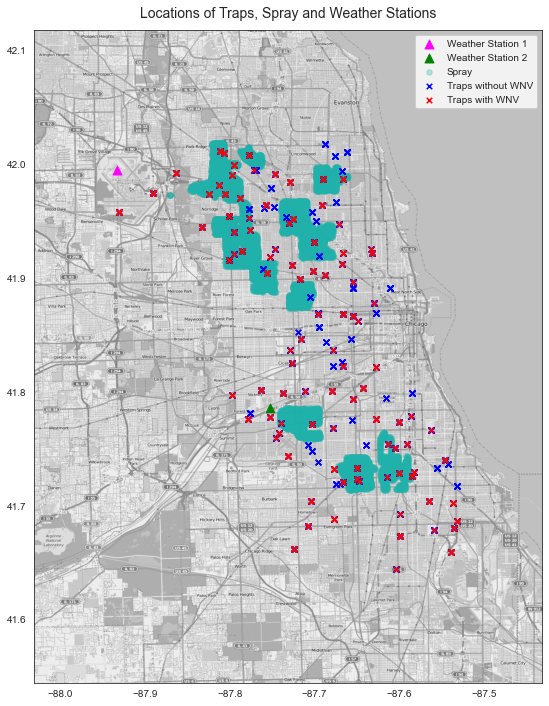

In [69]:
mapdata = np.loadtxt('./data/mapdata_copyright_openstreetmap_contributors.txt')

traps = train[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
long_lat_box = (train['Longitude'].min()-0.1, train['Longitude'].max()+0.1,
               train['Latitude'].min()-0.1, train['Latitude'].max()+0.1)

plt.figure(figsize=(10,12))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=long_lat_box, 
           aspect=aspect)

# weather station 1 longitude and latitude
station1_long = -87.933
station1_lat = 41.995
station1_scatter = plt.scatter(x=station1_long, y=station1_lat, marker='^', c='fuchsia', s=80)

# weather station 2 longitude and latitude
station2_long = -87.752
station2_lat = 41.786 
station2_scatter = plt.scatter(x=station2_long, y=station2_lat, marker='^', c='green', s=80)

# spray longitude and latitude
spray_long = spray['Longitude']
spray_lat = spray['Latitude']
spray_scatter = plt.scatter(x=spray_long, y=spray_lat, c='lightseagreen', s=30, alpha=0.3)

# traps without WNV
traps = train[['Date', 'Longitude', 'Latitude', 'WnvPresent']]
no_wnv_long = traps[traps['WnvPresent'] == 0]['Longitude']
no_wnv_lat = traps[traps['WnvPresent'] == 0]['Latitude']
no_wnv_scatter = plt.scatter(x=no_wnv_long, y=no_wnv_lat, marker='x', c='blue', s=30)

# trap with presence of WNV
wnv_long = traps[traps['WnvPresent'] == 1]['Longitude']
wnv_lat = traps[traps['WnvPresent'] == 1]['Latitude']
wnv_scatter = plt.scatter(x=wnv_long, y=wnv_lat, marker='x', c='red', s=30)

# Legend
plt.legend({'Weather Station 1': station1_scatter, 
            'Weather Station 2':station2_scatter,
            'Spray':spray_scatter,
            'Traps without WNV':no_wnv_scatter, 
            'Traps with WNV':wnv_scatter})

plt.title('Locations of Traps, Spray and Weather Stations', fontsize=14, y=1.01);

#### Weather Data

In [70]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   float64       
 3   Tmin         2944 non-null   float64       
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   float64       
 6   DewPoint     2944 non-null   float64       
 7   WetBulb      2944 non-null   float64       
 8   Heat         2944 non-null   float64       
 9   Cool         2944 non-null   float64       
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   float64       
 14  SnowFall     2944 non-null   float64       
 15  PrecipTotal  2944 non-null   float64       
 16  StnPre

In [71]:
weather_continuous = weather.select_dtypes(include = ['float']).columns

In [72]:
weather_continuous

Index(['Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
       'Depth', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

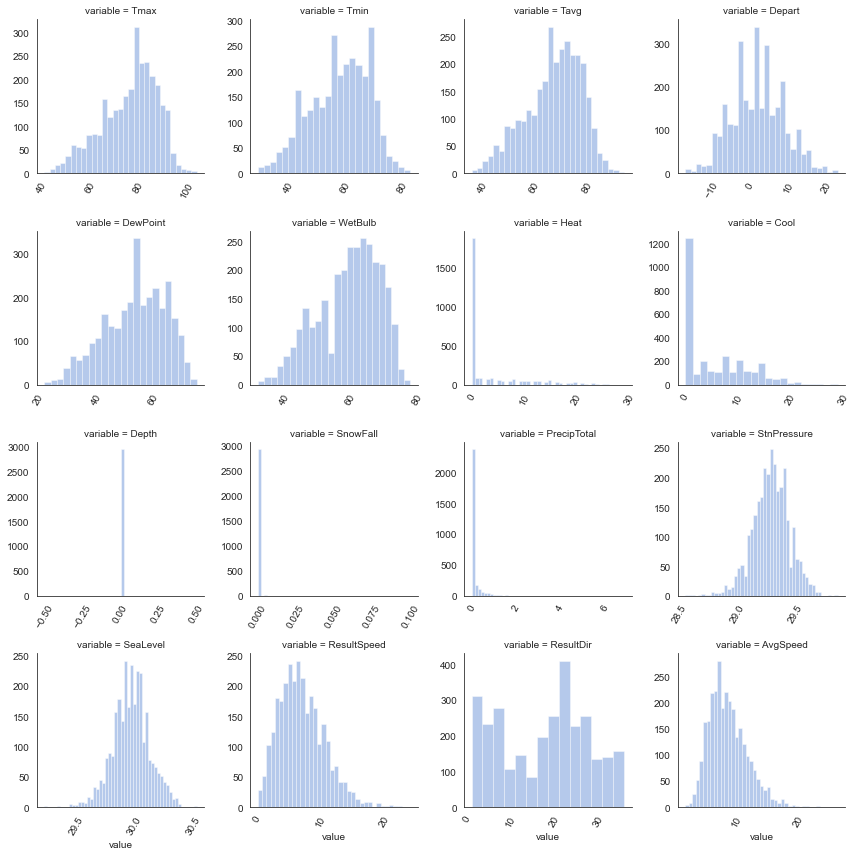

In [73]:
data = pd.melt(weather, value_vars=weather_continuous)
g = sns.FacetGrid(data, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.distplot, 'value', kde=False)
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()

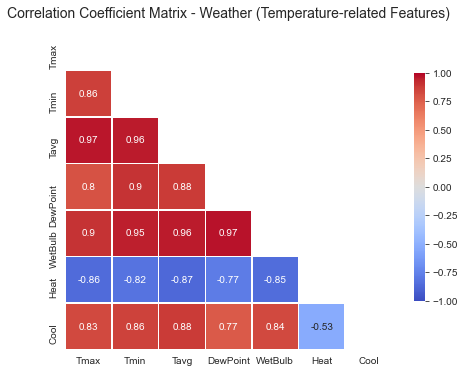

In [74]:
temperatures_col = ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool']

fig, ax = plt.subplots(figsize=(8,6))

corr = weather[temperatures_col].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

g = sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .7})
g.set_title('Correlation Coefficient Matrix - Weather (Temperature-related Features)', fontsize=14);

The temperature features show strong positive correlation. Of these, Tavg seems to have the strongest correlation with all the other temperature features. 

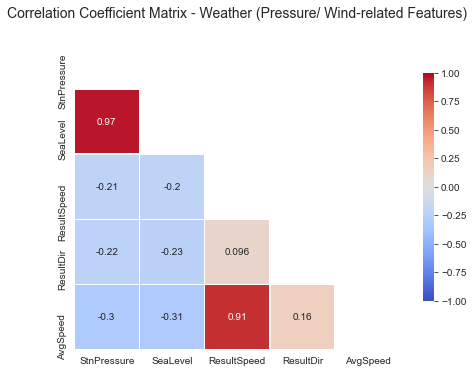

In [75]:
fig, ax = plt.subplots(figsize=(8,6))

corr = weather[['StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

g = sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .7})
g.set_title('Correlation Coefficient Matrix - Weather (Pressure/ Wind-related Features)', fontsize=14);

Strong correlation between AvgSpeed and ResultSpeed, as well as StnPressure and SeaLevel.
Hence we can use AvgSpeed and StnPressure these in modelling.

Based on the above discussion, we will keep the following columns in the weather dataset:

Station, Date, Tavg, PrecipTotal, StnPressure, AvgSpeed

In [76]:
# keep the useful columns and drop the rest
weather = weather[['Station', 'Date', 'Tavg', 'PrecipTotal', 'StnPressure', 'AvgSpeed']]

In [77]:
weather.head()

Station       Date  Tavg  PrecipTotal  StnPressure  AvgSpeed
0        1 2007-05-01  67.0          0.0        29.10       9.2
1        2 2007-05-01  68.0          0.0        29.18       9.6
2        1 2007-05-02  51.0          0.0        29.38      13.4
3        2 2007-05-02  52.0          0.0        29.44      13.4
4        1 2007-05-03  56.0          0.0        29.39      11.9

### TO DO!!!

#### Think about what to do with CodeSum

#### Feature Engineering: T-8 Day Window

- According to CDC, it takes about 7–10 days for an egg to develop into an adult mosquito [source](https://www.cdc.gov/westnile/resources/pdfs/FS_MosquitoLifeCycle-508.pdf)


In [78]:
# there are 2 options, 
# we can take T-8 window --> shift by 8 days
# we can calculate rolling mean for 4 days (day7-10), then shift it by 7 days


In [79]:
weather.head()

Station       Date  Tavg  PrecipTotal  StnPressure  AvgSpeed
0        1 2007-05-01  67.0          0.0        29.10       9.2
1        2 2007-05-01  68.0          0.0        29.18       9.6
2        1 2007-05-02  51.0          0.0        29.38      13.4
3        2 2007-05-02  52.0          0.0        29.44      13.4
4        1 2007-05-03  56.0          0.0        29.39      11.9

In [80]:
# reformat --> sort by station, then date, 
# as back up, we will assign this to 'weather_sorted' as a working df
# and keep the original 'weather' untouched till we get the final engineered feature :)


weather_sorted = weather.sort_values(['Station','Date'])

weather_sorted.head()

Station       Date  Tavg  PrecipTotal  StnPressure  AvgSpeed
0        1 2007-05-01  67.0        0.000        29.10       9.2
2        1 2007-05-02  51.0        0.000        29.38      13.4
4        1 2007-05-03  56.0        0.000        29.39      11.9
6        1 2007-05-04  58.0        0.005        29.31      10.8
8        1 2007-05-05  60.0        0.005        29.40      12.0

In [81]:
weather_sorted.tail()

Station       Date  Tavg  PrecipTotal  StnPressure  AvgSpeed
2935        2 2014-10-27  67.0        0.020        29.00      13.6
2937        2 2014-10-28  57.0        0.030        29.23      14.6
2939        2 2014-10-29  45.0        0.000        29.42       9.0
2941        2 2014-10-30  45.0        0.005        29.41       6.5
2943        2 2014-10-31  42.0        0.040        29.54      22.6

Now that we have the dataframe sorted by each station, and for each station are by date, we can start feature engineering:

- Option 1: Shift by T-8
- Option 2: Calculate rolling 4 days (day 7 to day 10), then shift by 7 days

<span style='color:blueviolet'> Let's discuss which option, and if we want to do for all 4 features?</span>

In [82]:
# Option 1 : Shift

weather_sorted['Tavg_m8'] = weather_sorted['Tavg'].shift(8)

In [83]:
weather_sorted.head(15)  # note we will lose first 8, maybe we can fill with the mean

Station       Date  Tavg  PrecipTotal  StnPressure  AvgSpeed  Tavg_m8
0         1 2007-05-01  67.0        0.000        29.10       9.2      NaN
2         1 2007-05-02  51.0        0.000        29.38      13.4      NaN
4         1 2007-05-03  56.0        0.000        29.39      11.9      NaN
6         1 2007-05-04  58.0        0.005        29.31      10.8      NaN
8         1 2007-05-05  60.0        0.005        29.40      12.0      NaN
10        1 2007-05-06  59.0        0.000        29.57      15.0      NaN
12        1 2007-05-07  65.0        0.005        29.38      10.5      NaN
14        1 2007-05-08  68.0        0.000        29.29       5.8      NaN
16        1 2007-05-09  69.0        0.130        29.21       6.2     67.0
18        1 2007-05-10  70.0        0.000        29.20       4.1     51.0
20        1 2007-05-11  61.0        0.000        29.33      12.9     56.0
22        1 2007-05-12  55.0        0.000        29.49      12.9     58.0
24        1 2007-05-13  56.0        0.000        29.49       8.1     60.0
26        1 2007-05-14  73.0        0.000        29.23      17.3     59.0
28        1 2007-05-15  69.0        0.380        29.13      12.3     65.0

In [84]:
weather_sorted.tail(15)

Station       Date  Tavg  PrecipTotal  StnPressure  AvgSpeed  Tavg_m8
2915        2 2014-10-17  56.0        0.010        29.05      12.7     57.0
2917        2 2014-10-18  46.0        0.020        29.44       8.7     52.0
2919        2 2014-10-19  47.0        0.000        29.39       9.0     50.0
2921        2 2014-10-20  58.0        0.000        29.23       9.1     55.0
2923        2 2014-10-21  52.0        0.000        29.51      11.6     65.0
2925        2 2014-10-22  50.0        0.000        29.62       5.1     61.0
2927        2 2014-10-23  52.0        0.005        29.46       8.4     56.0
2929        2 2014-10-24  61.0        0.000        29.31       5.8     56.0
2931        2 2014-10-25  64.0        0.000        29.27      10.4     56.0
2933        2 2014-10-26  55.0        0.000        29.28       5.4     46.0
2935        2 2014-10-27  67.0        0.020        29.00      13.6     47.0
2937        2 2014-10-28  57.0        0.030        29.23      14.6     58.0
2939        2 2014-10-29  45.0        0.000        29.42       9.0     52.0
2941        2 2014-10-30  45.0        0.005        29.41       6.5     50.0
2943        2 2014-10-31  42.0        0.040        29.54      22.6     52.0

In [85]:
# Option 2, rolling_mean for 4 days, then shift by 7 days

# first rolling avg by 4 days...

weather_sorted['Tavg_rolling4'] = weather_sorted['Tavg'].rolling(4).mean()
weather_sorted.head()

Station       Date  Tavg  PrecipTotal  StnPressure  AvgSpeed  Tavg_m8  \
0        1 2007-05-01  67.0        0.000        29.10       9.2      NaN   
2        1 2007-05-02  51.0        0.000        29.38      13.4      NaN   
4        1 2007-05-03  56.0        0.000        29.39      11.9      NaN   
6        1 2007-05-04  58.0        0.005        29.31      10.8      NaN   
8        1 2007-05-05  60.0        0.005        29.40      12.0      NaN   

   Tavg_rolling4  
0            NaN  
2            NaN  
4            NaN  
6          58.00  
8          56.25

In [86]:
# then shift it by 7 days

weather_sorted['Tavg_rolling4_shift7'] = weather_sorted['Tavg_rolling4'].shift(7)

In [87]:
weather_sorted.head(15)

Station       Date  Tavg  PrecipTotal  StnPressure  AvgSpeed  Tavg_m8  \
0         1 2007-05-01  67.0        0.000        29.10       9.2      NaN   
2         1 2007-05-02  51.0        0.000        29.38      13.4      NaN   
4         1 2007-05-03  56.0        0.000        29.39      11.9      NaN   
6         1 2007-05-04  58.0        0.005        29.31      10.8      NaN   
8         1 2007-05-05  60.0        0.005        29.40      12.0      NaN   
10        1 2007-05-06  59.0        0.000        29.57      15.0      NaN   
12        1 2007-05-07  65.0        0.005        29.38      10.5      NaN   
14        1 2007-05-08  68.0        0.000        29.29       5.8      NaN   
16        1 2007-05-09  69.0        0.130        29.21       6.2     67.0   
18        1 2007-05-10  70.0        0.000        29.20       4.1     51.0   
20        1 2007-05-11  61.0        0.000        29.33      12.9     56.0   
22        1 2007-05-12  55.0        0.000        29.49      12.9     58.0   
24        1 2007-05-13  56.0        0.000        29.49       8.1     60.0   
26        1 2007-05-14  73.0        0.000        29.23      17.3     59.0   
28        1 2007-05-15  69.0        0.380        29.13      12.3     65.0   

    Tavg_rolling4  Tavg_rolling4_shift7  
0             NaN                   NaN  
2             NaN                   NaN  
4             NaN                   NaN  
6           58.00                   NaN  
8           56.25                   NaN  
10          58.25                   NaN  
12          60.50                   NaN  
14          63.00                   NaN  
16          65.25                   NaN  
18          68.00                   NaN  
20          67.00                 58.00  
22          63.75                 56.25  
24          60.50                 58.25  
26          61.25                 60.50  
28          63.25                 63.00

#### Feature Engineering: Optimal Temperature Range

Optimal Temperature for breeding is between 50 (min to be active) and 80(for max activeness).


In [88]:
weather_sorted['Tavg_rolling4_shift7'] = weather_sorted['Tavg_rolling4_shift7'].astype(float)
weather_sorted['Tavg_rolling4_shift7'].dtype

dtype('float64')

In [89]:
for item, temp in weather_sorted['Tavg_rolling4_shift7'].items():
    if (temp >= 50) & (temp < 80):
        weather_sorted.loc[item, ['Opt_temp']] = 1
    else:
        weather_sorted.loc[item, ['Opt_temp']] = 0


KeyError: "None of [Index(['Opt_temp'], dtype='object')] are in the [columns]"

In [ ]:
weather_sorted.head(15)

#### Mapping Weather Data to Train and Test data

In [ ]:
def get_distance_km(lon1, lat1, lon2, lat2):
    """function to obtain distance between 2 locations
    input longitide and latitude of each location"""
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (
        acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    )

In [ ]:
get_distance_km(-87.933,41.995,-87.752,41.786)

In [ ]:
def nearest_station(lon,lat):
    """function to identify the nearest weather station
    from each trap location
    input: longtitude and latitude of each trap location"""
    station1_lat = 41.995
    station1_lon = -87.933
    station2_lat = 41.786
    station2_lon = -87.752
    station1= get_distance_km(station1_lon,station1_lat,lon,lat)
    station2= get_distance_km(station2_lon,station2_lat,lon,lat)
    if station1 < station2:
        return 1
    else:
        return 2

In [ ]:
for index in train.index:    
    train.loc[index,'Station'] = nearest_station(train.loc[index,'Longitude'],train.loc[index,'Latitude'])
train.tail()

## Cost Benefit analysis:
 - Benefit of spraying. 


In [90]:
test.head()

Id       Date                 Species  Trap  Latitude  Longitude  Month  \
0   1 2008-06-11  CULEX PIPIENS/RESTUANS  T002  41.95469 -87.800991      6   
1   2 2008-06-11          CULEX RESTUANS  T002  41.95469 -87.800991      6   
2   3 2008-06-11           CULEX PIPIENS  T002  41.95469 -87.800991      6   
3   4 2008-06-11        CULEX SALINARIUS  T002  41.95469 -87.800991      6   
4   5 2008-06-11         CULEX TERRITANS  T002  41.95469 -87.800991      6   

   Year  
0  2008  
1  2008  
2  2008  
3  2008  
4  2008

In [91]:
submission = pd.read_csv('./submission.csv')

In [92]:
prediction = pd.merge(test,submission, on = 'Id')

In [93]:
prediction.head()

Id       Date                 Species  Trap  Latitude  Longitude  Month  \
0   1 2008-06-11  CULEX PIPIENS/RESTUANS  T002  41.95469 -87.800991      6   
1   2 2008-06-11          CULEX RESTUANS  T002  41.95469 -87.800991      6   
2   3 2008-06-11           CULEX PIPIENS  T002  41.95469 -87.800991      6   
3   4 2008-06-11        CULEX SALINARIUS  T002  41.95469 -87.800991      6   
4   5 2008-06-11         CULEX TERRITANS  T002  41.95469 -87.800991      6   

   Year  Wnvpresent  
0  2008           0  
1  2008           0  
2  2008           0  
3  2008           0  
4  2008           0

In [94]:
WNV_present = prediction.loc[prediction['Wnvpresent']==1]

In [95]:
WNV_present.shape

(7594, 9)

In [99]:
train.head()

Date                 Species  Trap   Latitude  Longitude  \
0 2007-05-29           CULEX PIPIENS  T096  41.731922 -87.677512   
1 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
2 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T048  41.867108 -87.654224   
4 2007-05-29  CULEX PIPIENS/RESTUANS  T050  41.919343 -87.694259   

   NumMosquitos  WnvPresent  Month  Year  
0             1           0      5  2007  
1             1           0      5  2007  
2             1           0      5  2007  
3             1           0      5  2007  
4             1           0      5  2007

https://scentellegher.github.io/programming/2017/07/15/pandas-groupby-multiple-columns-plot.html

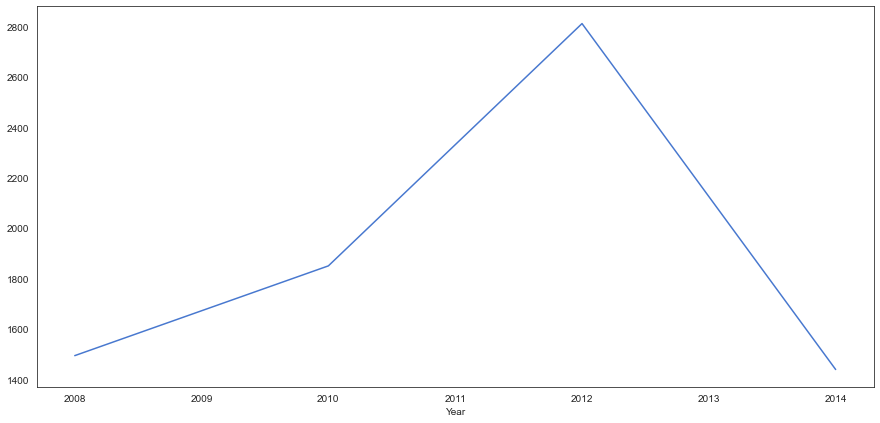

In [101]:
#plot data
fig, ax = plt.subplots(figsize=(15,7))
WNV_present.groupby('Year').sum()['Wnvpresent'].plot(ax=ax);

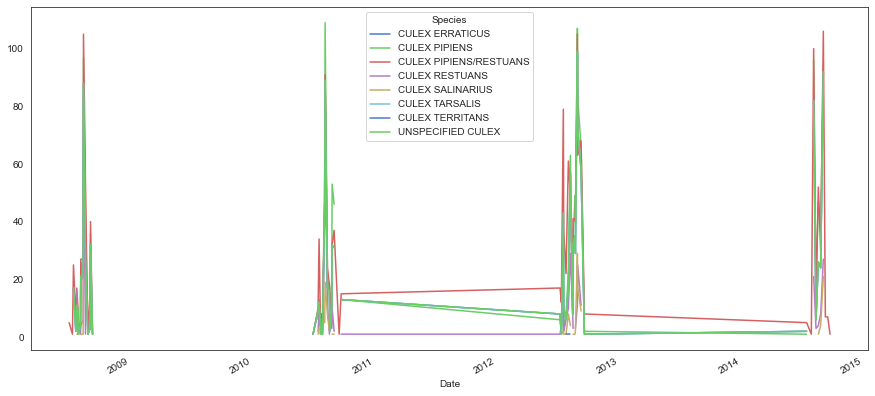

In [103]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
WNV_present.groupby(['Date','Species']).count()['Year'].unstack().plot(ax=ax)

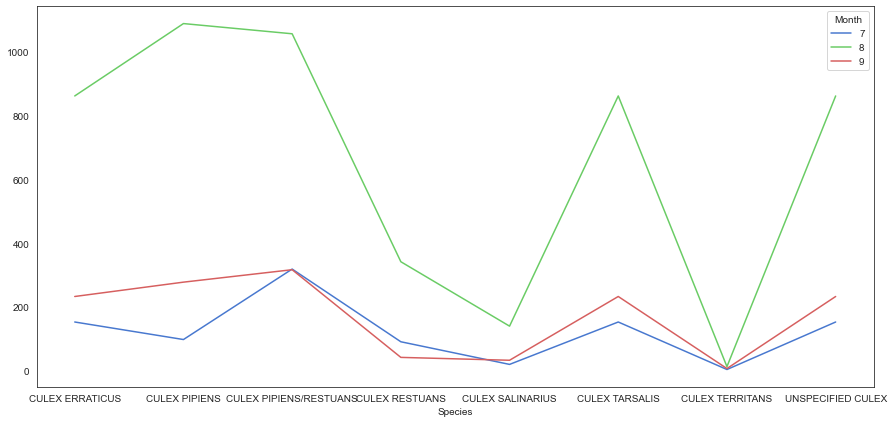

In [121]:
#plot data
fig, ax = plt.subplots(figsize=(15,7))
WNV_present.groupby(['Species','Month']).count()['Year'].unstack().plot(ax=ax);

In [106]:
spray.head()

Date        Time   Latitude  Longitude
95 2011-09-07  7:52:52 PM  41.981433 -87.787777
96 2011-09-07  7:53:02 PM  41.980998 -87.787778
97 2011-09-07  7:53:12 PM  41.980560 -87.787762
98 2011-09-07  7:53:22 PM  41.980198 -87.787758
99 2011-09-07  7:53:32 PM  41.979752 -87.787765

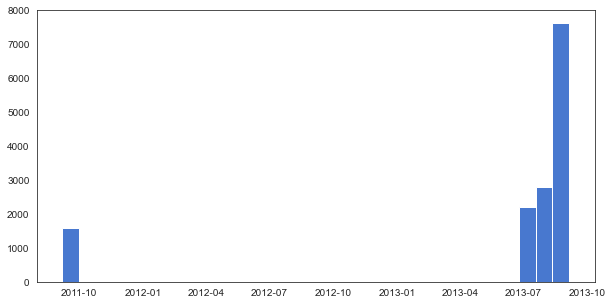

In [110]:
# Plot the hist to see the spread
plt.figure(figsize=(10,5))
plt.hist(spray['Date'], bins=30,);